In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.optimize
import warnings
from scipy.integrate import trapz

# suppress numpy overflow warnings
warnings.filterwarnings('ignore')

k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
h = 6.626176e-34
hbar = 1.054571e-34
ev_to_j = 1.6e-19

def fermi(eps, mu, T):
    return 1/(1+np.exp((eps-mu)/(k_b*T)))


def fit(x, activation_energy, I_0):
    x = np.array(x) + 1e-20
    return I_0 * np.exp(-activation_energy/ (k_b * x))

def fit_thermal_activation(temps, currents):
    fit_func = fit
    p0 = [k_b, 1]
    ps, pcov = scipy.optimize.curve_fit(fit_func, np.array(temps), np.array(currents)
                                        , p0=p0)
    E_a, I_0 = ps
    f = lambda x, E_a = E_a, I_0= I_0: fit_func(x, E_a, I_0)
    return f, (E_a, I_0)

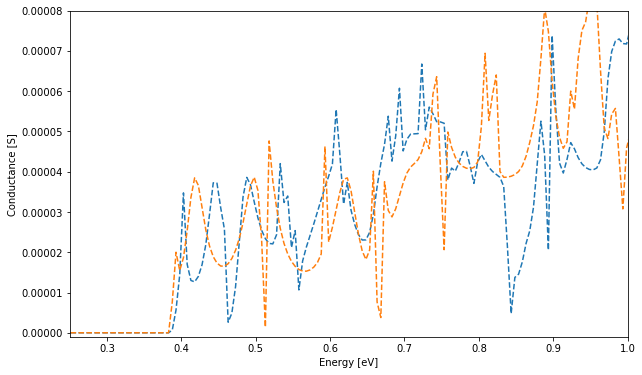

In [30]:
### Comparing conductance plots ###

data = np.load("data/thermal_activation_parallel_5mV.npy", allow_pickle=True)
_, energies, total, spin_downs, spin_ups = np.array(data)

### Manual E_z shift ###
E_z = 0 * ev_to_j
plt.figure(figsize=(10,6))
# plt.plot((energies-E_z)/ev_to_j, spin_downs)
# plt.plot((energies+E_z)/ev_to_j, spin_ups, )
###
data = np.load("data/thermal_activation_parallel_5mV_Z100meV.npy", allow_pickle=True)
_, energies, total, spin_downs, spin_ups = np.array(data)
plt.plot((energies)/ev_to_j, spin_downs, "--")
plt.plot((energies)/ev_to_j, spin_ups,"--")
plt.xlim(0.25,1)
plt.ylabel("Conductance [S]")
plt.xlabel("Energy [eV]")
plt.ylim(-1e-6,8e-5)
# plt.savefig("graphs/Comparison between simulated and manual zeeman shifts")
plt.show()

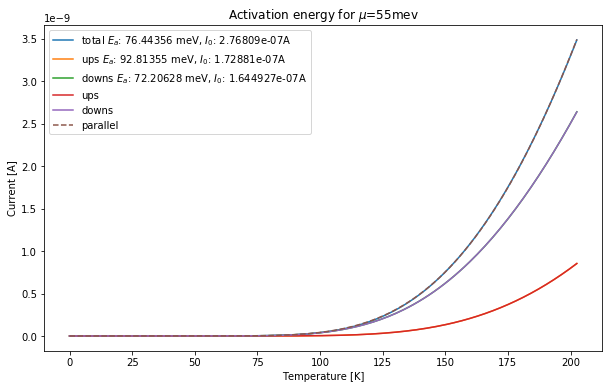

In [71]:

v_sd = 5/1000
left_pot = v_sd / 2 * ev_to_j
right_pot = -v_sd / 2 * ev_to_j


name = "55"
E_z = 0.01 * ev_to_j #dont' comment this out!!!
data = np.load("data/150_angstroms/5mV_gapless.npy", allow_pickle=True)
_, energies, total, spin_downs, spin_ups = np.array(data)

doping_level = float(name)/1000 * ev_to_j
mu_left = doping_level+left_pot
mu_right = doping_level+right_pot

currents = []
ups = []
downs = []

t_max = lambda x: 400*np.exp(-(x/ev_to_j*15)**2)
temps = np.linspace(0,t_max(doping_level), 200)
for temp in temps:
    occupation_differences_up \
        = fermi(energies+E_z, mu_left, temp) - fermi(energies+E_z, mu_right, temp)

    occupation_differences_down \
        = fermi(energies-E_z, mu_left, temp) - fermi(energies-E_z, mu_right, temp)

    down_current = trapz(spin_downs * occupation_differences_down / q_e, energies)
    up_current = trapz(spin_ups * occupation_differences_up / q_e, energies)

    ups.append(up_current)
    downs.append(down_current)
    currents.append(up_current+down_current)

plt.figure(figsize=(10,6))

f, ps = fit_thermal_activation(temps, currents)
fitted = f(temps)
plt.plot(temps, fitted, label="total $E_a$: {} meV, $I_0$: {}A".format(round(1000*ps[0]/ev_to_j,5), round(ps[1],13)))

f, ps = fit_thermal_activation(temps, ups)
fitted = f(temps)
plt.plot(temps, fitted, label="ups $E_a$: {} meV, $I_0$: {}A".format(round(1000*ps[0]/ev_to_j,5), round(ps[1],13)))

f, ps = fit_thermal_activation(temps, downs)
fitted = f(temps)
plt.plot(temps, fitted, label="downs $E_a$: {} meV, $I_0$: {}A".format(round(1000*ps[0]/ev_to_j,5), round(ps[1],13)))


plt.plot(temps, ups, label = "ups")
plt.plot(temps, downs, label = "downs")
plt.plot(temps, currents,"--", label = "parallel", )

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Current [A]")
plt.title("Activation energy for $\mu$={}mev".format(name))
# plt.savefig("graphs/Activation energies/5mV_gapless/activation {}mev".format(name))

plt.show()

In [72]:
from tqdm import tqdm

v_sd = 5/1000
left_pot = v_sd / 2 * ev_to_j
right_pot = -v_sd / 2 * ev_to_j

_, energies, total, spin_downs, spin_ups = np.array(data)


levels = np.linspace(-0.5,.5, 201) * ev_to_j
diffs = []
activation_energies = []
for doping_level in tqdm(levels):
    mu_left = doping_level+left_pot
    mu_right = doping_level+right_pot


    currents = []
    ups = []
    downs = []

    t_max = lambda x: 400*np.exp((-x*4)**2)
    temps = np.linspace(0,t_max(doping_level), 200)
    for temp in temps:
        occupation_differences_up \
        = fermi(energies+E_z, mu_left, temp) - fermi(energies+E_z, mu_right, temp)

        occupation_differences_down \
            = fermi(energies-E_z, mu_left, temp) - fermi(energies-E_z, mu_right, temp)

        down_current = trapz(spin_downs * occupation_differences_down / q_e, energies)
        up_current = trapz(spin_ups * occupation_differences_up / q_e, energies)

        ups.append(up_current)
        downs.append(down_current)
        currents.append(up_current+down_current)

    f, ps = fit_thermal_activation(temps, currents)
    activation_energies.append(ps[0]/ev_to_j)
    f, ps_ups = fit_thermal_activation(temps, ups)
    f, ps_downs = fit_thermal_activation(temps, downs)
    diffs.append((ps_downs[0] - ps_ups[0]) / ev_to_j)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:13<00:00, 15.45it/s]


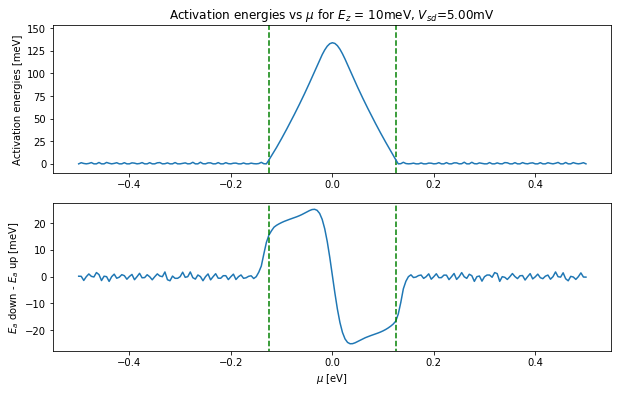

In [73]:
fig, axs = plt.subplots(2,figsize=(10,6))

band_start = 0.125

axs[0].plot(band_start * np.ones(50), np.linspace(-10, 500), "--", color="green")
axs[0].plot(-band_start * np.ones(50), np.linspace(-10, 500), "--", color="green")

axs[0].plot(levels/ev_to_j, 1000*np.array(activation_energies))

axs[0].set_ylim(-10, max(activation_energies) * 1000 + 20)
axs[0].set_ylabel("Activation energies [meV]")
axs[0].set_title("Activation energies vs $\mu$ for $E_z$ = 10meV, $V_{sd}$=%.2fmV" % (1000*v_sd))

axs[1].plot(levels/ev_to_j, 1000 * np.array(diffs))
axs[1].set_ylabel("$E_a$ down - $E_a$ up [meV]")
axs[1].set_xlabel("$\mu$ [eV]")
axs[1].plot(band_start * np.ones(50), np.linspace(-1000, 1000), "--", color="green")
axs[1].plot(-band_start * np.ones(50), np.linspace(-1000, 1000), "--", color="green")

bound = 1000*max(abs(np.array(diffs))) *1.1
axs[1].set_ylim(-bound,bound)


plt.savefig("graphs/150 angstrom dot/Activation energies/Activation energy for doping levels, manual 10meV")
plt.show()

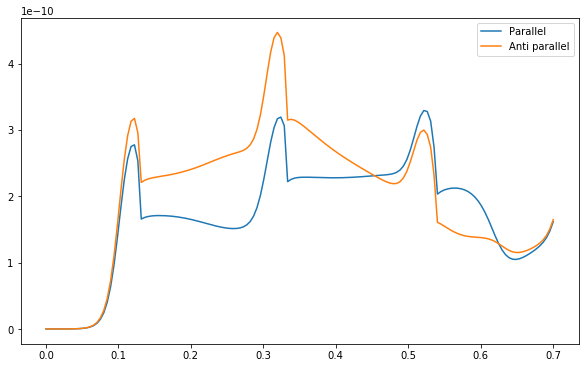

0.04228187919463087


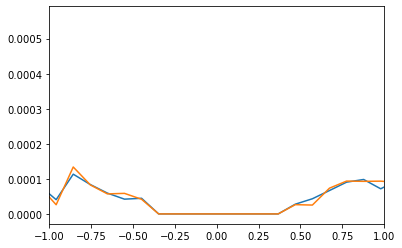

0.3673469387755105
17


In [45]:
data = []
data2 = []
voltages = np.linspace(0, 0.7, 150)
data.extend(np.load("data/iv_parallel.npy", allow_pickle=True))
data2.extend(np.load("data/iv_anti_parallel.npy", allow_pickle=True))


currents = []
currents2 = []
for current, energies, total, spin_downs, spin_ups in data[::]:
    currents.append(current)

for current, energies, total, spin_downs, spin_ups in data2[::]:
    currents2.append(current)

plt.figure(figsize=(10,6))
plt.plot(voltages, currents, label = "Parallel")
plt.plot(voltages[:len(currents2)], currents2, label = "Anti parallel")
plt.legend()
# plt.xlim(0,0.1)
# plt.ylim(0,1e-10)
# plt.yscale('log')
plt.show()

current, energies, total, spin_downs, spin_ups = data[9]
plt.plot(energies/ev_to_j, total)
current, energies, total, spin_downs, spin_ups = data2[9]
print(voltages[9])
plt.plot(energies/ev_to_j, total)
plt.xlim(-1,1)
plt.show()

for i in range(len(energies)):
    if total[-i] == 0:
        print(energies[-i]/ev_to_j)
        print(i)
        break

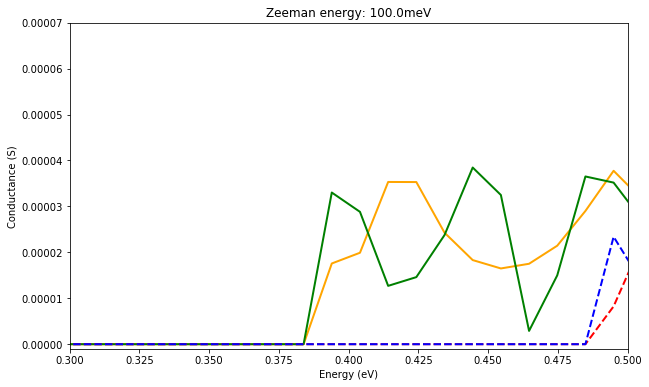

In [51]:
%matplotlib inline

E_zs = np.linspace(0,0.1, 30)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(0.3, 0.5), ylim=(-1e-6, 7e-5))
line, = ax.plot([], [], lw=2, label="Up", color="orange")
line2, = ax.plot([], [], lw=2, label="Down", color='green')

line3, = ax.plot([], [], "--",lw=2, label="Up", color="red", )
line4, = ax.plot([], [], "--",lw=2, label="Down", color='blue')
# ax.legend()

mid = -0.5
def animate(frame):
    E_z, f1, f2 = frame
    current_sum, energies, total, spin_downs, spin_ups = f1

    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Conductance (S)")

    line.set_data(energies/q_e, np.array(spin_ups))
    line2.set_data(energies/q_e, np.array(spin_downs))

    current_sum, energies, total, spin_downs, spin_ups = f2
    line3.set_data(energies/q_e, np.array(spin_ups))
    line4.set_data(energies/q_e, np.array(spin_downs))

    # ax.set_title("Source-drain voltage = {}V, $I_p$ = {}A, $I_a$ = {}A".format(round(v_sd,3), round(current,13), round(current2,13)))
    ax.set_title("Zeeman energy: {}meV".format(round(E_z*1000,3)))
    return line, line2

# frames = zip(voltages,data,data2)
frames = np.load("data/no_leads_magnetic_field_5mV_plotting.npy", allow_pickle=True)
frames2 = np.load("data/leads_magnetic_field_5mV_plotting.npy", allow_pickle=True)
frames = zip(E_zs,frames, frames2)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=1000/15
                               , blit=True, save_count=len(frames2))

anim.save('graphs/zeeman_energy_comparison.mp4', fps=3, extra_args=['-vcodec', 'libx264'])
plt.show()